In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['figure.figsize'] = 8, 6

In [4]:
mnist = pd.read_csv('data/mnist_train.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
np.random.seed(1)
n_sam = 50
mnist50 = pd.DataFrame(columns=mnist.columns, dtype='int64')
for i in range(10):
    samples = mnist[mnist.label==i].sample(n_sam, replace=False)
    mnist50 = pd.concat([mnist50, samples], ignore_index=True)
mnist50.label.value_counts()

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
Name: label, dtype: int64

In [6]:
mnist50.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
mnist50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 3.0 MB


In [8]:
X = mnist50.drop(['label'], axis=1)
y = mnist50.label

In [206]:
def plot_mnist(img, label=''):
    plt.imshow(img.reshape((28,28)), cmap='gray')
    plt.title(str(label))
    plt.xticks([])
    plt.yticks([])

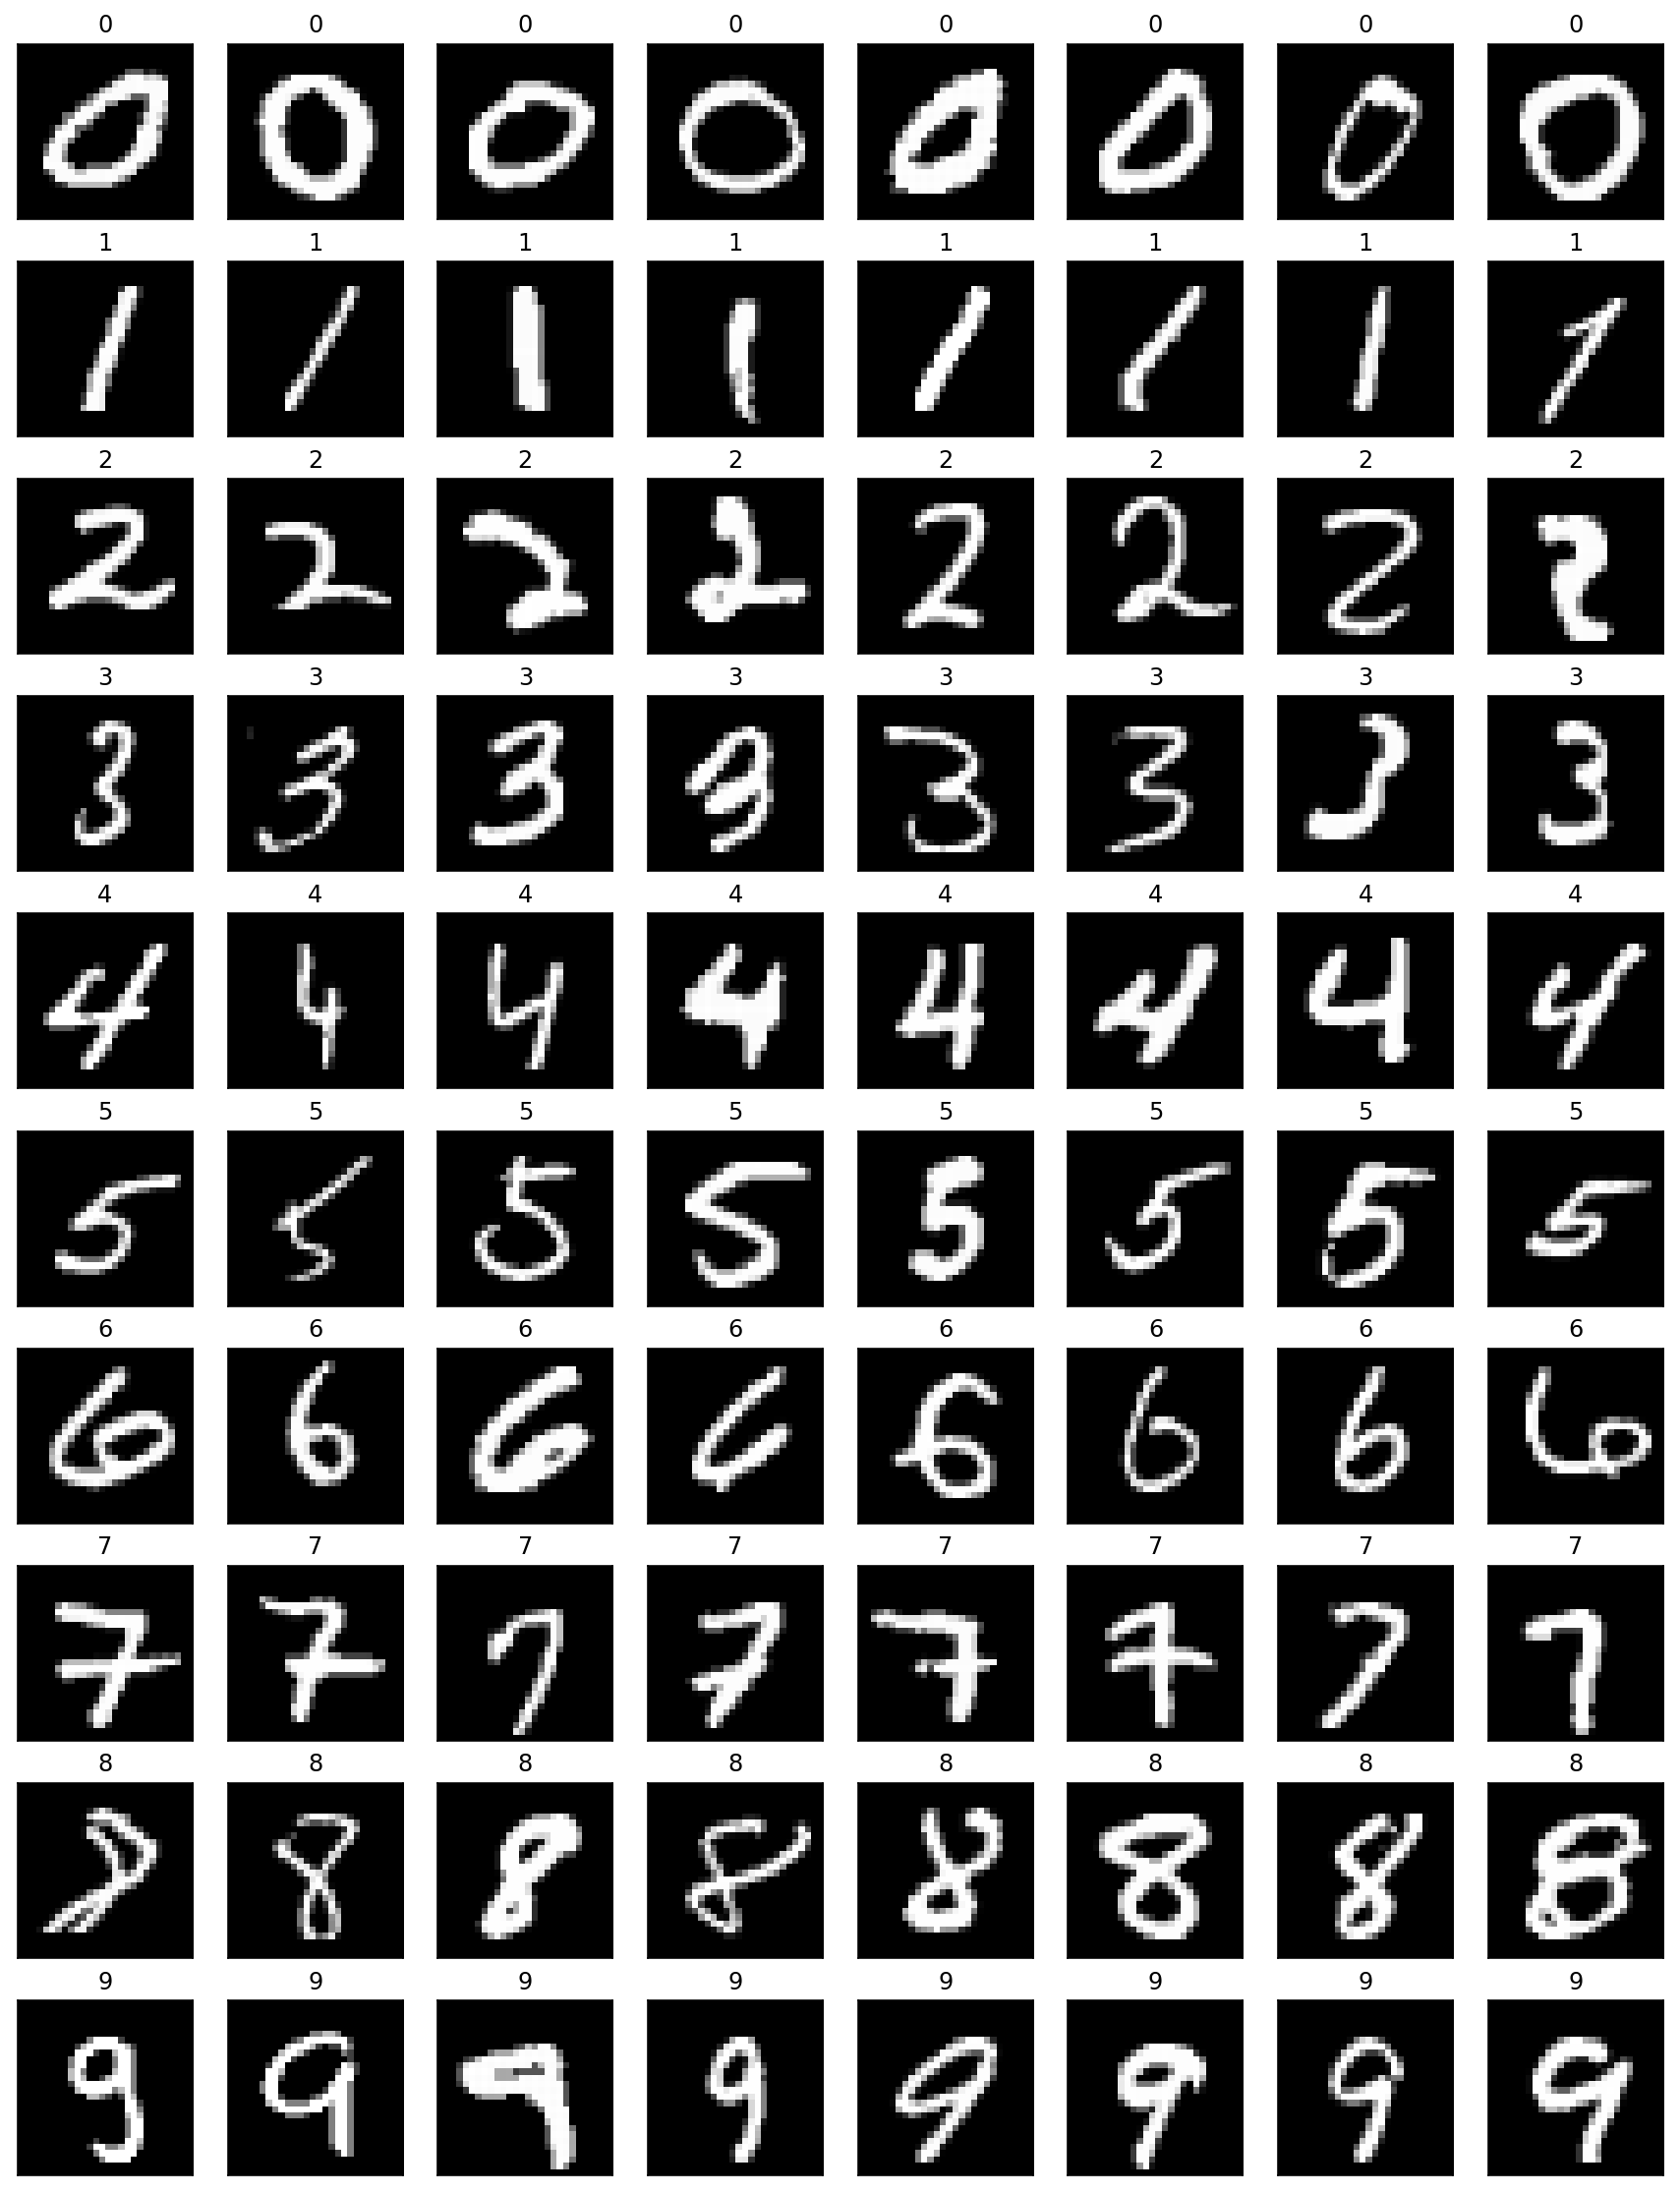

In [303]:
np.random.seed(0)
n_sam = 8
samples = {i:y[y==i].sample(n_sam, replace=False).index for i in range(10)}
plt.figure(figsize=(15,20))
for i in range(10*n_sam):
    dig, sam = i//n_sam, i%n_sam
    plt.subplot(10,n_sam,i+1)
    img = X.iloc[samples[dig][sam]].values.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(str(y[samples[dig][sam]]))
    plt.xticks([])
    plt.yticks([])

In [209]:
features = mnist50.drop('label', axis=1)
label = mnist50.label

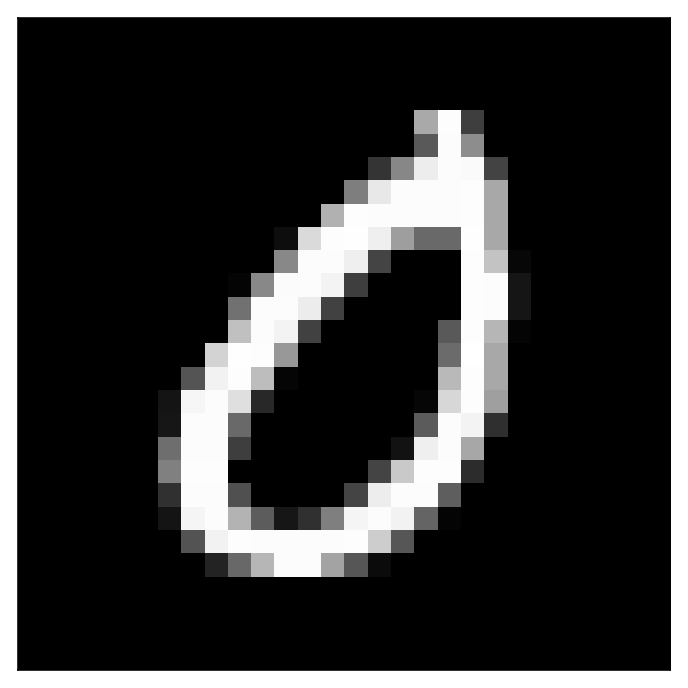

In [210]:
ind = 0
img = features.iloc[ind].values
plot_mnist(img)

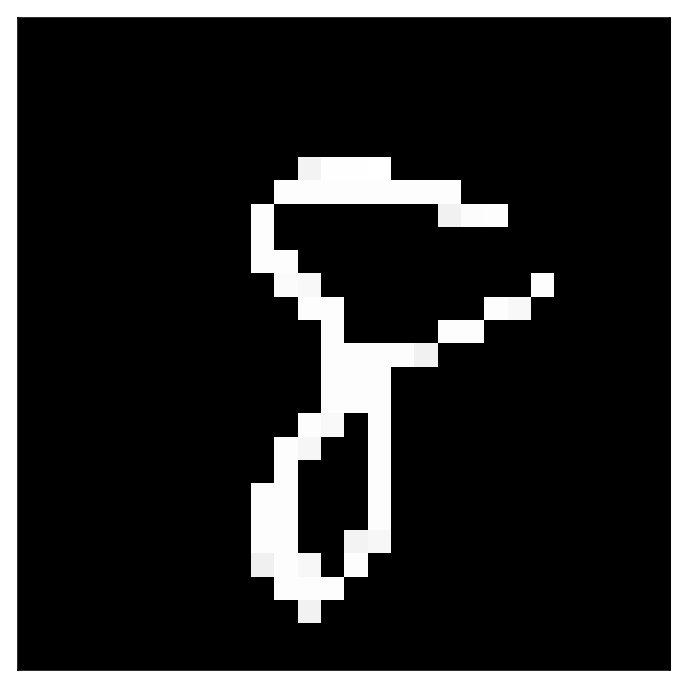

In [211]:
ind = 410
img = np.array(features.iloc[ind].values)
img[img<240]=0
plot_mnist(img)

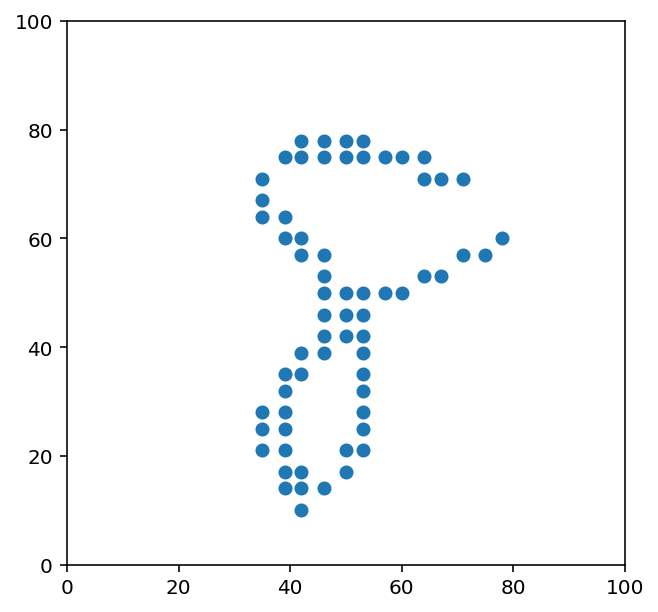

In [212]:
r, c = np.where(img.reshape((28,28))>240)
x_coor, y_coor = (c*100/28).astype('int64'), ((28-r)*100/28).astype('int64')
plt.figure(figsize=(5,5))
plt.scatter(x_coor, y_coor)
plt.xlim((0,100))
plt.ylim((0,100))
plt.show()

In [366]:
def img2coord(img, scale=100, pixval_min=0):
    r, c = np.where(img.reshape((28,28))>=pixval_min)
    x_coor, y_coor = (c*100/28).astype('int64'), ((28-r)*100/28).astype('int64')
    xycoors = np.concatenate((x_coor.reshape(-1,1), y_coor.reshape(-1,1)), axis=1)
    return xycoors

def mnist2penpoints(img, pixval_min=100, scale=100, plot=''):
    xycoors = img2coord(img, scale=scale, pixval_min=pixval_min)
    kmeans = KMeans(n_clusters=8)
    kmeans.fit(xycoors)
    pred = kmeans.predict(xycoors)
    if plot=='both':
        plt.scatter(xycoors[:,0], xycoors[:,1], c=pred, cmap='tab10')
        plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*',color='k')
        plt.xlim((0,100))
        plt.ylim((0,100))
        plt.xticks([])
        plt.yticks([])
    elif plot=='centroid':
        plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*',color='k')
        plt.xlim((0,100))
        plt.ylim((0,100))
        plt.xticks([])
        plt.yticks([])        
    return kmeans, xycoors

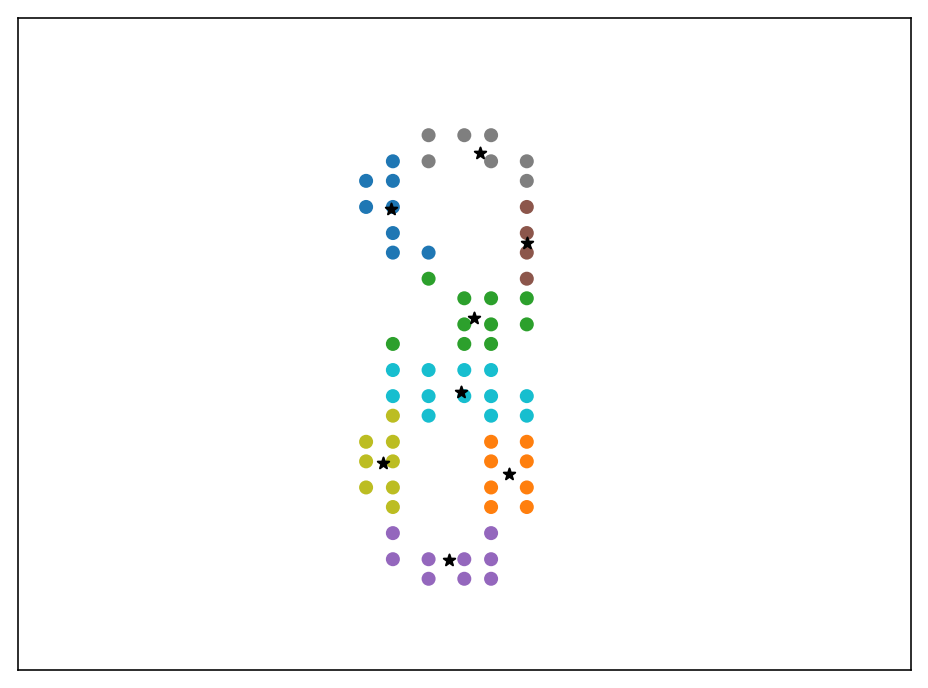

In [367]:
ind=449
c = mnist2penpoints(features.iloc[ind].values, plot='both')

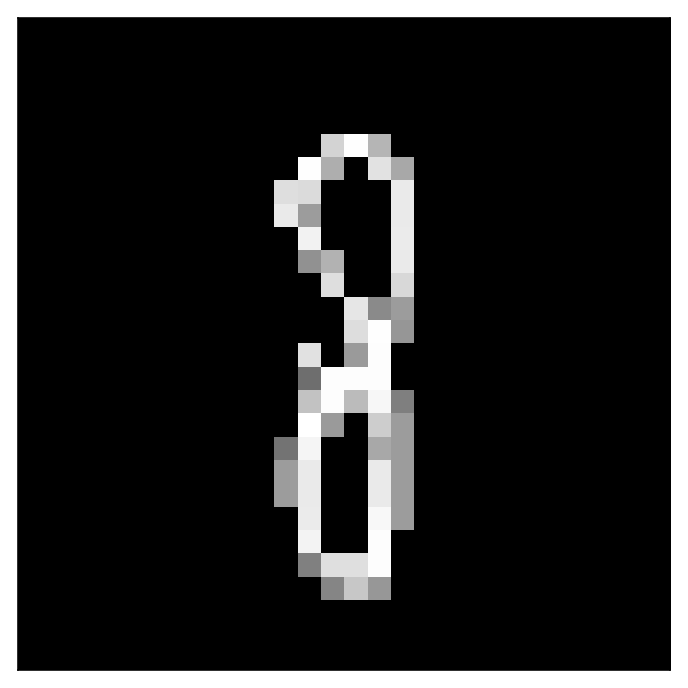

In [368]:
img = np.array(features.iloc[ind].values)
img[img<=100]=0
plot_mnist(img)

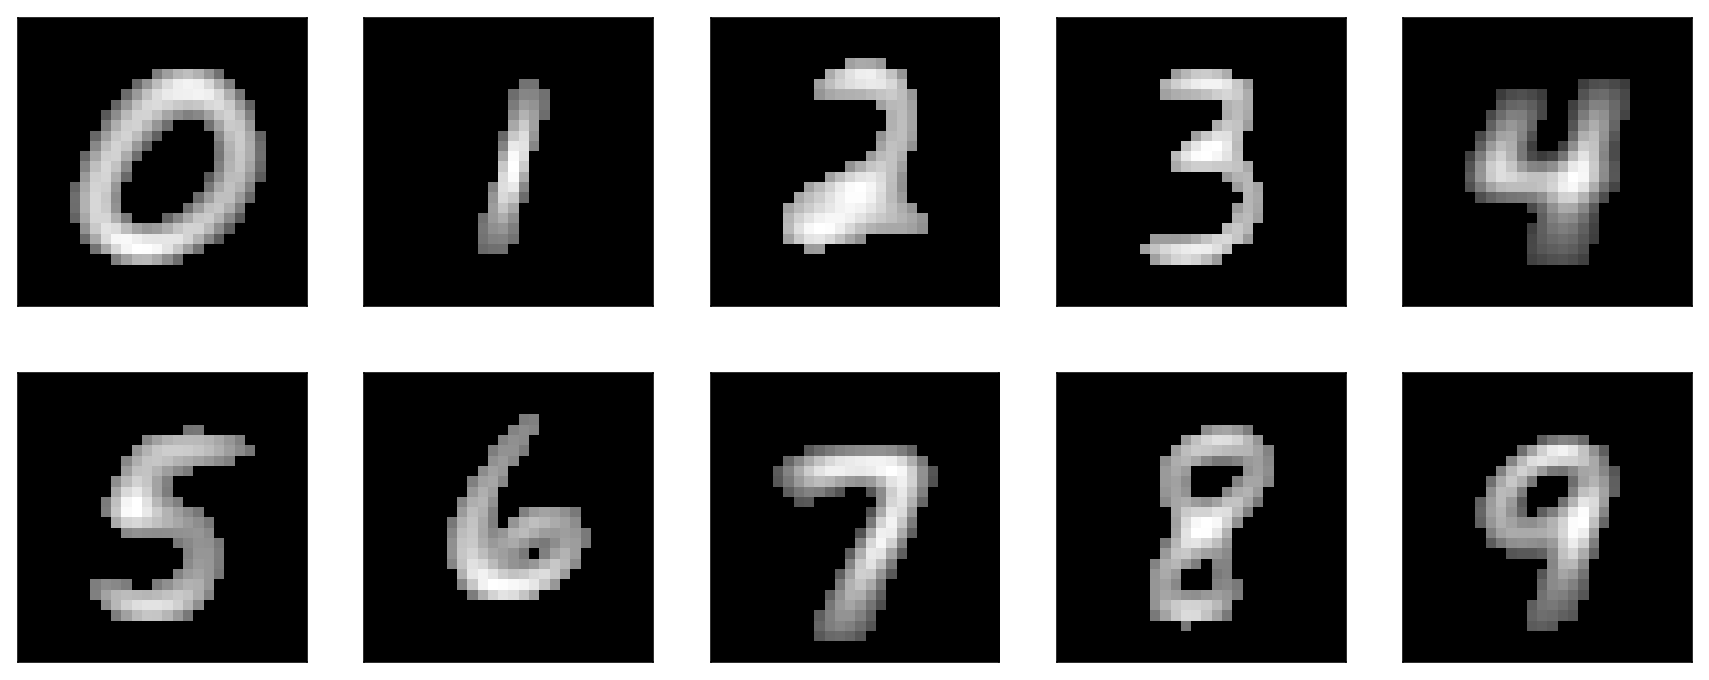

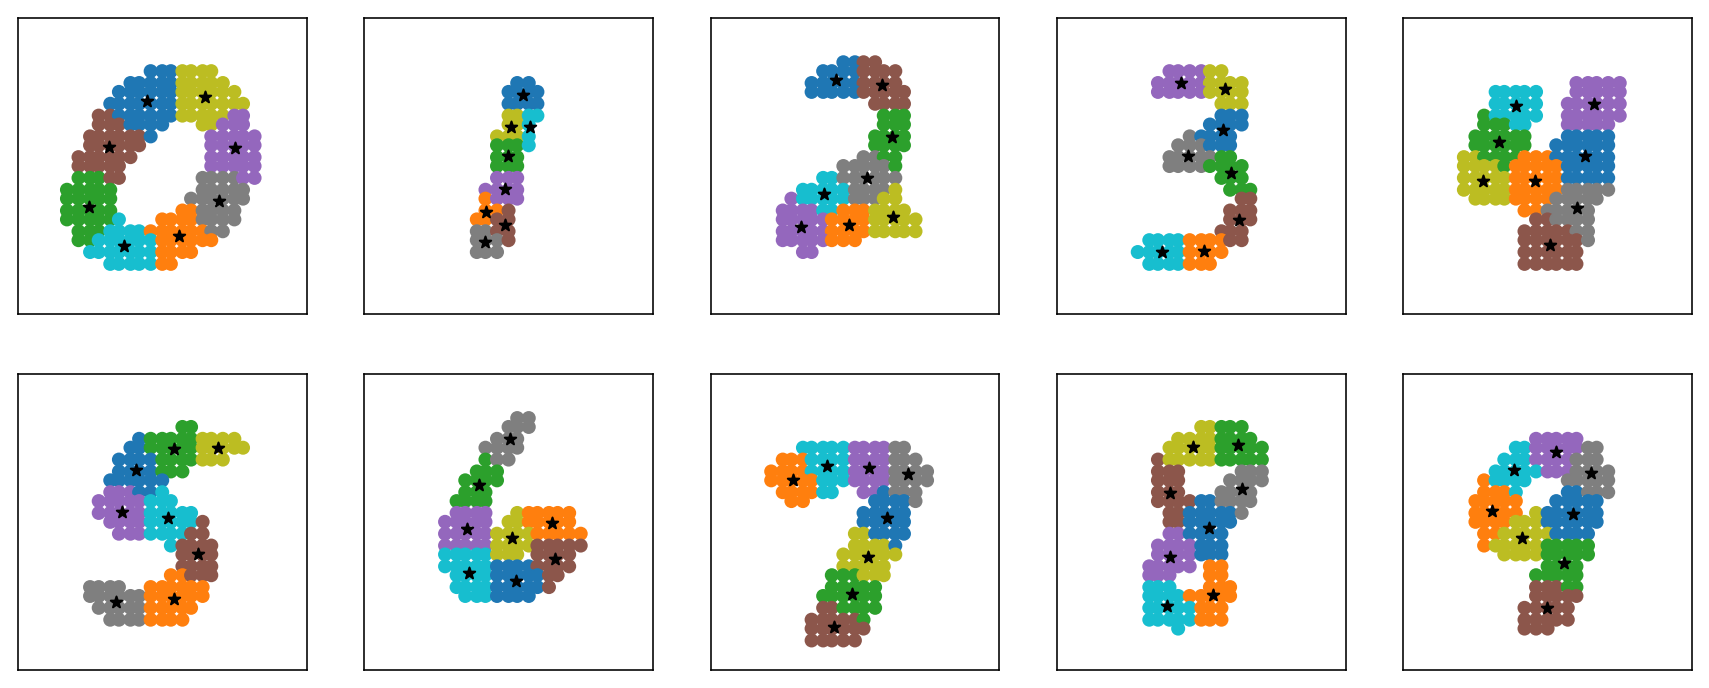

In [349]:
np.random.seed(2)
average_mnist = mnist.groupby('label').mean().astype('int64').values
thld = {0:70,1:100,2:100,3:120,4:50,5:80,6:100,7:60,8:100,9:70}
r, c = 2, 5
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img= average_mnist[i]
    img[img<thld[i]] = 0
    plot_mnist(img)
plt.show()
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img= average_mnist[i]
    img[img<thld[i]] = 0
    pc = mnist2penpoints(img, pixval_min=thld[i], plot='both')
plt.show()

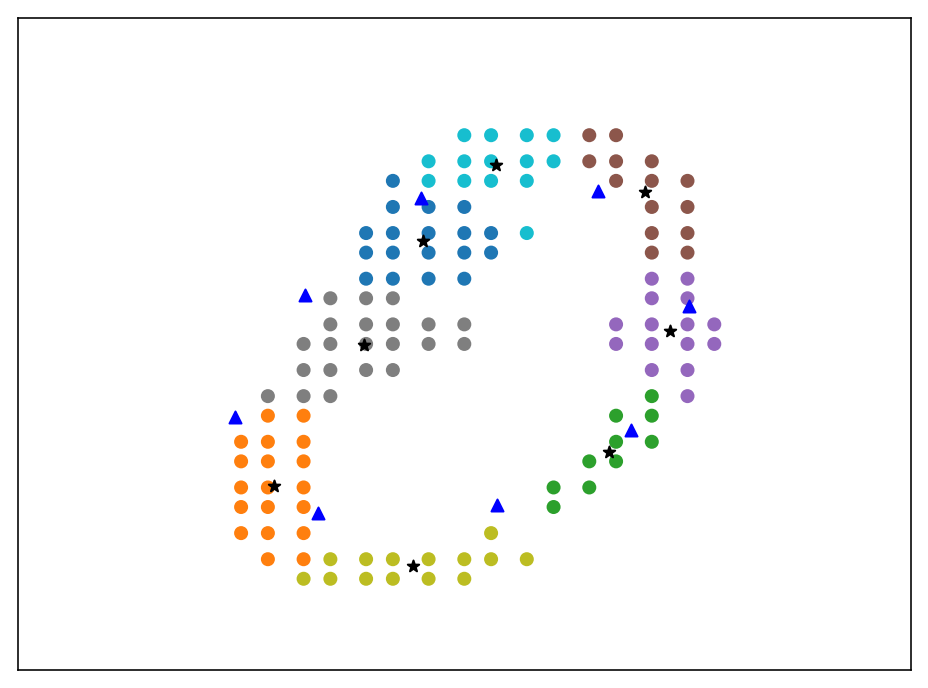

In [389]:
kmt, _ = mnist2penpoints(average_mnist[0], pixval_min=thld[i])
tmplt_0 = km.cluster_centers_
img_0 = img2coord(features.iloc[30].values, pixval_min=thld[0])
km0, _ = mnist2penpoints(features.iloc[30].values, pixval_min=thld[i], plot='both')
plt.scatter(tmplt_0[:,0], tmplt_0[:,1], marker='^',color='b')

In [394]:
def mse(c1, c2):
    return np.mean((c1-c2)**2)
x = np.array([[1,2], [1,2]])
y= np.array([[1,2], [1,2]])
mse(x,y)

0.0

In [395]:
mse(tmplt_0, km0.cluster_centers_)

716.1124802010347